In [526]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from config import Config as c

In [625]:
import matplotlib.pyplot as plt
import json
import pandas as pd

In [528]:
import os
import random
from pathlib import Path

In [590]:
ham_dataset_dir = 'ham_minified'
nv_test_num = 1000
batch_size = 48
seed = 42

In [591]:
IMG_SIZE = (224, 224)

In [592]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Preprocessing and Augmentation

In [593]:
images = list(os.walk(ham_dataset_dir + '/nv'))[0][2]
images_to_save = random.sample(images, nv_test_num)
images_to_delete = [image for image in images if image not in images_to_save]
for image_to_delete in images_to_delete:
    path = Path(f'{ham_dataset_dir}/nv/{image_to_delete}')
    path.unlink(missing_ok=False)

In [594]:
train_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                            labels='inferred', shuffle=True, subset='training', image_size=IMG_SIZE,
                                                            batch_size=batch_size, label_mode='categorical', seed=seed)

val_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                          labels='inferred', shuffle=True, subset='validation', image_size=IMG_SIZE,
                                                          batch_size=batch_size, label_mode='categorical', seed=seed)

Found 2826 files belonging to 4 classes.
Using 1979 files for training.
Found 2826 files belonging to 4 classes.
Using 847 files for validation.


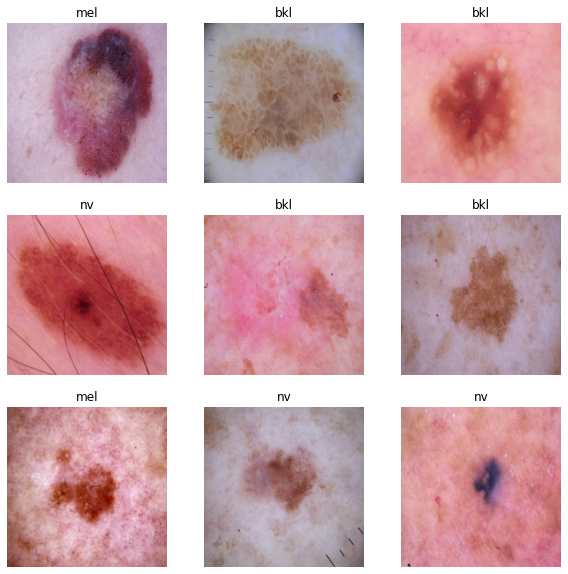

In [424]:
# class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))

# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [595]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [596]:
val_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(val_ds)]
val_labels = np.concatenate(val_labels, axis=None)

test_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(test_ds)]
test_labels = np.concatenate(test_labels, axis=None)

In [597]:
print('Size of validation dataset: %d' % len(val_labels))
print('Size of test dataset: %d' % len(test_labels))

Size of validation dataset: 415
Size of test dataset: 432


In [598]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 9
Number of test batches: 9


In [599]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

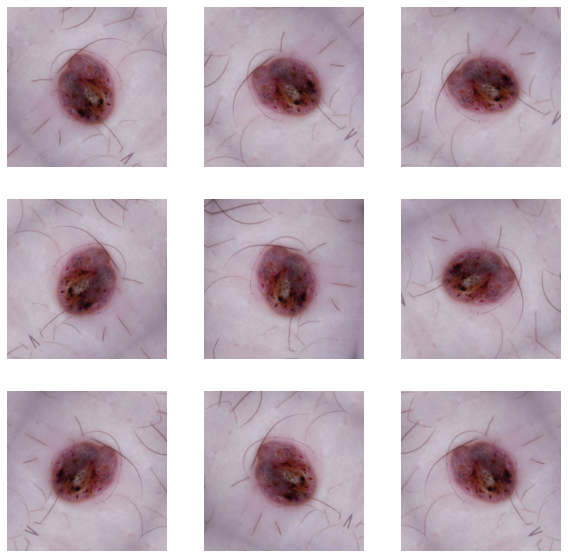

In [36]:
# for image, _ in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

In [37]:
# rescale = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)

In [600]:
# train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Define Model

In [601]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [602]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(48, 7, 7, 2048)


In [603]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [604]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(48, 2048)


In [605]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(48, 4)


In [606]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [607]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [608]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [609]:
# model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [610]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_9   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [611]:
len(model.trainable_variables)

2

### Model Training

In [612]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_ds)

9/9 [==============================] - 3s 150ms/step - loss: 1.8572 - accuracy: 0.2386


In [613]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.86
initial accuracy: 0.24


In [614]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
42/42 [==============================] - 7s 132ms/step - loss: 1.5678 - accuracy: 0.3931 - val_loss: 1.3270 - val_accuracy: 0.4337
Epoch 2/50
42/42 [==============================] - 5s 124ms/step - loss: 1.3901 - accuracy: 0.4229 - val_loss: 1.1269 - val_accuracy: 0.4964
Epoch 3/50
42/42 [==============================] - 5s 125ms/step - loss: 1.2454 - accuracy: 0.4704 - val_loss: 1.0716 - val_accuracy: 0.5060
Epoch 4/50
42/42 [==============================] - 5s 125ms/step - loss: 1.1676 - accuracy: 0.4952 - val_loss: 1.0023 - val_accuracy: 0.5518
Epoch 5/50
42/42 [==============================] - 5s 125ms/step - loss: 1.0935 - accuracy: 0.5240 - val_loss: 0.9461 - val_accuracy: 0.5855
Epoch 6/50
42/42 [==============================] - 5s 126ms/step - loss: 1.0504 - accuracy: 0.5457 - val_loss: 0.8819 - val_accuracy: 0.6217
Epoch 7/50
42/42 [==============================] - 5s 124ms/step - loss: 0.9983 - accuracy: 0.5735 - val_loss: 0.8902 - val_accuracy: 0.6145
Epoch 

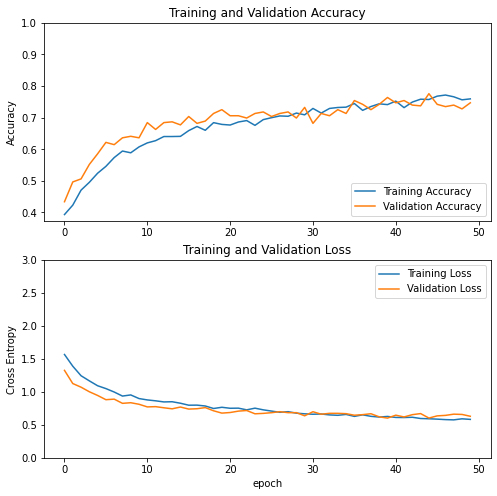

In [615]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('plots/history_nv_' + str(nv_test_num) + '.pdf')

In [571]:
plt.show()

In [616]:
with open('history/history_nv' + str(nv_test_num) + '.json', 'w') as f:
        json.dump(history.history, f, indent=4)

### Evaluation, Test Set

In [618]:
test_list = list(test_ds)

In [619]:
preds = []
labels = []

for batch_num in range(len(test_list)):
    image_batch, label_batch = test_list[batch_num]
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    this_pred = model.predict_on_batch(image_batch)
    this_classes = np.argmax(this_pred, axis=1)
    
    pred = tf.keras.utils.to_categorical(this_classes, num_classes=4)
    
    y_test_non_category = [ np.argmax(t) for t in label_batch ]
    y_predict_non_category = [ np.argmax(t) for t in pred ]
    
    labels.extend(y_test_non_category)
    preds.extend(y_predict_non_category)

In [620]:
label_names = sorted(os.listdir(ham_dataset_dir))

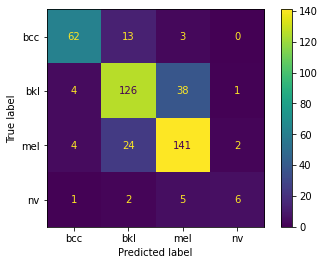

In [623]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_names)
disp.plot()
plt.savefig('plots/confusion_matrix_nv_' + str(nv_test_num) + '.pdf')

In [524]:
plt.show()

In [624]:
print("Model tested on a total of {} images".format(len(labels)))

Model tested on a total of 432 images


### Precision Recall Metrics

In [588]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [589]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1-score: 0.75

Macro Precision: 0.79
Macro Recall: 0.72
Macro F1-score: 0.75

Weighted Precision: 0.75
Weighted Recall: 0.75
Weighted F1-score: 0.75

Classification Report

              precision    recall  f1-score   support

         bcc       0.89      0.71      0.79        77
         bkl       0.72      0.72      0.72       160
         mel       0.71      0.81      0.75       163
          nv       0.83      0.62      0.71        32

    accuracy                           0.75       432
   macro avg       0.79      0.72      0.75       432
weighted avg       0.75      0.75      0.75       432



In [621]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.78

Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.76
Macro Recall: 0.70
Macro F1-score: 0.72

Weighted Precision: 0.78
Weighted Recall: 0.78
Weighted F1-score: 0.77

Classification Report

              precision    recall  f1-score   support

         bcc       0.87      0.79      0.83        78
         bkl       0.76      0.75      0.75       169
         mel       0.75      0.82      0.79       171
          nv       0.67      0.43      0.52        14

    accuracy                           0.78       432
   macro avg       0.76      0.70      0.72       432
weighted avg       0.78      0.78      0.77       432



In [629]:
report_dict = classification_report(labels, preds, target_names=label_names, output_dict=True)
# print(report_dict)
report_data = pd.DataFrame(report_dict)
report_data.to_csv('reports/report_nv_'+str(nv_test_num), index=False)

In [630]:
print(report_data)

                 bcc         bkl         mel         nv  accuracy   macro avg  \
precision   0.873239    0.763636    0.754011   0.666667  0.775463    0.764388   
recall      0.794872    0.745562    0.824561   0.428571  0.775463    0.698392   
f1-score    0.832215    0.754491    0.787709   0.521739  0.775463    0.724039   
support    78.000000  169.000000  171.000000  14.000000  0.775463  432.000000   

           weighted avg  
precision      0.776473  
recall         0.775463  
f1-score       0.774131  
support      432.000000  


### Class Weight Stuff

In [9]:
class_weights = {}
for i in range(len(class_weights_list)):
    class_weights[i] = class_weights_list[i]

In [5]:
classes = train_ds.class_names
train_ds_single_batch = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.2, color_mode='rgb',
                                                                         labels='inferred', shuffle=True, subset='training', image_size=(256, 256),
                                                                         batch_size=1, seed=seed)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.


In [6]:
print(classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
y = np.array([label.numpy()[0] for _, label in train_ds_single_batch])
class_weights_list = compute_class_weight('balanced', classes=np.unique(y), y=y)
print(class_weights_list)

[ 4.31913747  2.77135939  1.31107838 12.86035313  1.26611884  0.2138986
  9.78266178]
